# Mise en place du notebook

## Import des modules

In [1]:
%autosave 1200

Autosaving every 1200 seconds


In [136]:
# imports pour la production
import warnings
from IPython.core.display import HTML
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import VGG16
from keras.models import Model
from pyspark.conf import SparkConf
from pyspark import SparkContext
from tqdm.notebook import tqdm_notebook
from pympler.asizeof import asizeof
import boto3
from time import time
from datetime import datetime


## Gestion des paramètres d'affichage de Jupyter

In [3]:
plt.style.use('seaborn')

warnings.filterwarnings(category=FutureWarning, action='ignore')

# pour gérer l'affichage des dataframes pandas
pd.options.display.max_rows = 100
pd.options.display.max_columns = 200
pd.set_option("colheader_justify", "left")

# pour gérer l'affichage des arrays numpy
# 230 sur config bureau, 165 sur config portable
np.set_printoptions(linewidth=165)

# pour afficher les gros fichiers sur toute la largeur de l'écran
HTML("<style>.container { width:100% }</style>")

## Liens utiles

Enoncé OC : https://openclassrooms.com/fr/paths/164/projects/633/assignment  
Liens vers les données Kaggle : https://www.kaggle.com/moltean/fruits  
        

## Configurations d'accès à AWS : clés SSH, tokens, credentials, etc...

### Tokens AWS CLI

A renseigner une seule fois, lors la première connexion avec AWS CLI

### Connexions SSH au cluster manager EMR

Clé privée dans un fichier .pem dans ~/.ssh sur PC local.  
  
Fichier ~/.ssh/config sur PC local :  
Host *.eu-west-1.compute.amazonaws.com  
IdentityFile ~/.ssh/cle_irelande.pem


## Gestion des chemins

In [4]:
dirpath = os.getcwd()
print("Working directory is :", dirpath)

Working directory is : /home/jim/projet8


In [5]:
# Liste les fichiers du working directory
print("Liste les fichiers du working directory :", os.listdir(dirpath))

Liste les fichiers du working directory : ['Projet 8 v08.ipynb', 'df_output_2048_fruits_-_spark_en_local.csv', 'cat.jpg', 'Projet 8 v04.ipynb', 'Projet 8 v13.ipynb', 'Projet 8 v01.ipynb', 'Projet 8 v17.ipynb', 'Projet 8 v07.ipynb', 'Projet 8 v06.ipynb', 'input', 'Projet 8 v14.ipynb', 'Projet 8 v05.ipynb', 'filename', 'Projet 8 v12.ipynb', 'Tests Jupyter v1.ipynb', 'tmp', 'Projet 8 v19.ipynb', 'Projet 8 v09.ipynb', '.ipynb_checkpoints', 'Projet 8 v10.ipynb', 'Projet 8 v03.ipynb', 'Projet 8 v11.ipynb', 'Projet 8 v16.ipynb', 'Projet 8 v18.ipynb', 'df_output_64_fruits_-_spark_en_local.csv', 'Projet 8 v02.ipynb', 'Projet 8 v15.ipynb', 'df_output_30_fruits.csv']


In [6]:
# Répertoires de photos de fruits en local
list_input_dir = sorted(os.listdir(os.path.join(dirpath, 'input')))
print("Répertoires de photos de fruits en local :", list_input_dir)

Répertoires de photos de fruits en local : ['Apple Braeburn', 'Apricot', 'Avocado', 'Banana', 'Beetroot', 'Blueberry', 'Cactus fruit', 'Cantaloupe 1', 'Carambula', 'Cauliflower']


In [112]:
os.makedirs(os.path.join(dirpath, 'logs/'), exist_ok=True)

## Dataframe output de la feature extraction

### Initialisation

In [7]:
# dataframe pandas avec 4096+1 colonnes
def initialize_df_output():
    return pd.DataFrame(columns = [f'dim_{i}' for i in range(4096)]+['path'])

df_output = initialize_df_output()
df_output

,dim_0,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7,dim_8,dim_9,dim_10,dim_11,dim_12,dim_13,dim_14,dim_15,dim_16,dim_17,dim_18,dim_19,dim_20,dim_21,dim_22,dim_23,dim_24,dim_25,dim_26,dim_27,dim_28,dim_29,dim_30,dim_31,dim_32,dim_33,dim_34,dim_35,dim_36,dim_37,dim_38,dim_39,dim_40,dim_41,dim_42,dim_43,dim_44,dim_45,dim_46,dim_47,dim_48,dim_49,dim_50,dim_51,dim_52,dim_53,dim_54,dim_55,dim_56,dim_57,dim_58,dim_59,dim_60,dim_61,dim_62,dim_63,dim_64,dim_65,dim_66,dim_67,dim_68,dim_69,dim_70,dim_71,dim_72,dim_73,dim_74,dim_75,dim_76,dim_77,dim_78,dim_79,dim_80,dim_81,dim_82,dim_83,dim_84,dim_85,dim_86,dim_87,dim_88,dim_89,dim_90,dim_91,dim_92,dim_93,dim_94,dim_95,dim_96,dim_97,dim_98,dim_99,...,dim_3997,dim_3998,dim_3999,dim_4000,dim_4001,dim_4002,dim_4003,dim_4004,dim_4005,dim_4006,dim_4007,dim_4008,dim_4009,dim_4010,dim_4011,dim_4012,dim_4013,dim_4014,dim_4015,dim_4016,dim_4017,dim_4018,dim_4019,dim_4020,dim_4021,dim_4022,dim_4023,dim_4024,dim_4025,dim_4026,dim_4027,dim_4028,dim_4029,dim_4030,dim_4031,dim_4032,dim_4033,dim_4034,dim_4035,dim_4036,dim_4037,dim_4038,dim_4039,dim_4040,dim_4041,dim_4042,dim_4043,dim_4044,dim_4045,dim_4046,dim_4047,dim_4048,dim_4049,dim_4050,dim_4051,dim_4052,dim_4053,dim_4054,dim_4055,dim_4056,dim_4057,dim_4058,dim_4059,dim_4060,dim_4061,dim_4062,dim_4063,dim_4064,dim_4065,dim_4066,dim_4067,dim_4068,dim_4069,dim_4070,dim_4071,dim_4072,dim_4073,dim_4074,dim_4075,dim_4076,dim_4077,dim_4078,dim_4079,dim_4080,dim_4081,dim_4082,dim_4083,dim_4084,dim_4085,dim_4086,dim_4087,dim_4088,dim_4089,dim_4090,dim_4091,dim_4092,dim_4093,dim_4094,dim_4095,path


### Fonction de concaténation des features extraites

In [8]:
def append_to_dataframe(concatenated_dataframe, np_array, path):
    """Appends a vector to the output dataframe.
    Args : 
    - concatenated_dataframe : dataframe of dimension 4097.
    - np_array : numpy array (output of VGG16 feature extraction).
    - path : string of the path to the image.
    Returns :
    - dataframe to which (np_vector, path) has been appended.
    """
    df_single_line = pd.DataFrame(np_array, columns=[f'dim_{i}' for i in range(4096)])
    df_single_line['path'] = path
    return pd.concat([concatenated_dataframe, df_single_line])

In [26]:
# Test unitaire
test_np_array = np.linspace(0,1,4096).reshape(1,4096)   # same shape as VGG16 output

for i in range(1000):
    df_output = append_to_dataframe(df_output, test_np_array, 'blabla')

In [27]:
asizeof(df_output) / 2**30

0.09959038347005844

250ms pour 100 concaténations.  
5.1s pour 1000 concaténations.  Le df_output pèse 97 Mo.
4min50s pour 10000 concaténations. 61s pour 1000 concaténations additionnelles en partant d'un df_output à 10000 lignes.  Le df_output pèse 1.0 Go pour 11000 lignes.
  
Parfait, c'est rapide.  
Mais au-delà de 10000 concaténations, le df_output commence à devenir un peu trop gros.  

## Logger vers S3

In [161]:
def timestamp():
    return datetime.now().strftime("%Y-%m-%d--%H-%M-%S")

def logger_s3(s3_bucket, logfile, log, log_to_shell=True):
    """Appends log to logfile. Uploads each update to S3 bucket.
    Args : 
        - s3_bucket (Bucket).
        - logfile (string) .
        - log (string).
        - log_to_shell (bool) : si True, imprime également dans le std.out.
    Returns : /
    """
    time_log = timestamp() + " : " + log + "\n"
    if log_to_shell : print(time_log)
    with open("./logs/"+ logfile, 'a') as f:
        f.write(time_log)
    s3_bucket.upload_file("./logs/"+ logfile, 'logs/' + logfile)    
    
# test unitaire
s3_bucket = boto3.resource('s3').Bucket('oc-projet-8')
logfile = "Log for job started " + timestamp() + ".txt"
logger_s3(s3_bucket, logfile, "hello")
logger_s3(s3_bucket, logfile, "world")

2022-01-16--15-32-42 : hello

2022-01-16--15-32-42 : world



## VGG-16

On déroule cette méthodologie :  
    https://machinelearningmastery.com/how-to-use-transfer-learning-when-developing-convolutional-neural-network-models/  
Chapitre : Pre-Trained Model as Feature Extractor Preprocessor  

In [9]:
# load model
model_vgg16 = VGG16()
# remove the output layer
model_vgg16 = Model(inputs=model_vgg16.inputs, outputs=model_vgg16.layers[-2].output)

2022-01-16 10:18:14.316792: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-16 10:18:14.317181: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-16 10:18:14.317290: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-01-16 10:18:14.317373: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-01-16 10:18:14.317442: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [10]:
print("Poids de la variable = ", round(asizeof(model_vgg16) / 2**10), "ko")

Poids de la variable =  271 ko


In [11]:
print("Poids des weights = ", round(asizeof(model_vgg16.weights) / 2**10), "ko")

Poids des weights =  58 ko


### Fonction de feature extraction SANS Spark (en local)

In [12]:
def VGG16_extracteur(nom_image):
    """Transforme un fichier image en un vecteur de dimension 4096.
    Args : 
    - nom_image : chemin d'accès à l'image.
    Returns :
    - array numpy (vecteur de dimension 4096).
    """
    # load an image from file
    image = load_img(nom_image, target_size=(224, 224))
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    # reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # prepare the image for the VGG model
    image = preprocess_input(image)
    # get extracted features
    im_features = model_vgg16.predict(image)
    return im_features


# test unitaire
arr_cat = VGG16_extracteur('cat.jpg')
arr_cat

array([[0.      , 0.      , 4.132894, ..., 0.      , 0.      , 1.660564]], dtype=float32)

### Fonction de feature extraction AVEC Spark (en local) - OLD

In [13]:
def VGG16_extracteur_spark_old(nom_image):
    """Transforme un fichier image en un vecteur de dimension 4096.
    Args : 
    - nom_image : chemin d'accès à l'image.
    Returns :
    - liste de dimension 4097 (4096 dimensions de VGG16 + nom_image).
    """
    # load an image from file
    image = load_img(nom_image, target_size=(224, 224))
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    # reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # prepare the image for the VGG model
    image = preprocess_input(image)
    # get extracted features
    im_features = model_vgg16.predict(image)
    # convert to list and add nom_image
    im_features = im_features[0].tolist()
    im_features.append(nom_image)
    gc.collect()
    return im_features


# test unitaire
arr_cat = VGG16_extracteur_spark_old('cat.jpg')
display(arr_cat)
display(arr_cat[4096])

[0.0,
 0.0,
 4.132894039154053,
 2.9331538677215576,
 0.0,
 0.0,
 0.3639414310455322,
 0.0,
 0.0,
 4.0563130378723145,
 0.0,
 2.4108474254608154,
 0.0,
 0.0,
 0.0,
 2.742780923843384,
 0.0,
 0.018078476190567017,
 0.0,
 0.0,
 2.9647316932678223,
 1.7499921321868896,
 0.0,
 5.3167643547058105,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 9.953381538391113,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.2348507046699524,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.3391169011592865,
 0.0,
 0.0,
 0.9910150766372681,
 0.0,
 0.0,
 5.558553695678711,
 0.0,
 9.433260917663574,
 1.9430336952209473,
 0.7856622934341431,
 0.0,
 0.58051598072052,
 0.0,
 0.0,
 0.0,
 1.9110187292099,
 0.0,
 0.9012514352798462,
 0.0,
 3.67254376411438,
 0.0,
 0.0,
 0.0,
 0.0,
 2.1046841144561768,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.6071363687515259,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 2.8195128440856934,
 0.0,
 0.0,
 2.487450361251831,
 0.0,
 0.0,
 0.0,
 0.

'cat.jpg'

### Fonction de feature extraction AVEC Spark (en local)

In [42]:
def VGG16_extracteur_spark(path, nom_image, model):
    """Transforme un fichier image en un vecteur de dimension 4096.
    Args : 
    - path : chemin vers les images (chemin local ou 'S3').
    - nom_image : chemin d'accès à l'image (exemple : 'Apple Braeburn/r_173_100.jpg')
    - model : model_vgg16 ou bc_model_vgg16.
    Returns :
    - liste de dimension 4097 (4096 dimensions de VGG16 + nom_image).
    """
    # create path to the image stored locally
    if path == 'S3':
        s3_bucket = boto3.resource('s3').Bucket('oc-projet-8')  # lent (réfléchir à la possibilité d'un unique appel par chaque exécuteur : broadcast ?)
        s3_bucket.download_file('input/' + nom_image, '/tmp/img')
        path_nom_image = '/tmp/img'
    else:
        path_nom_image = os.path.join(path, nom_image)
    # load the image for keras processing
    image = load_img(path_nom_image, target_size=(224, 224))
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    # reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # prepare the image for the VGG model
    image = preprocess_input(image)
    # get extracted features
    im_features = model.predict(image)
    # convert to list and add nom_image
    im_features = im_features[0].tolist()
    im_features.append(nom_image)
    return im_features


# test unitaire
# arr_cat = VGG16_extracteur_spark('.', 'cat.jpg', model_vgg16)
# display(arr_cat)
# display(arr_cat[4096])

# test unitaire
! rm /tmp/img
arr_cat = VGG16_extracteur_spark('S3', 'Apple Braeburn/r_173_100.jpg', model_vgg16)
display(arr_cat)
display(arr_cat[4096])

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 7.005156517028809,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.3920884430408478,
 0.0,
 0.0,
 0.0,
 0.45305946469306946,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.627370834350586,
 0.0,
 0.0,
 0.0,
 0.0,
 0.247361421585083,
 0.0,
 0.4626164138317108,
 0.0,
 0.0,
 1.0825210809707642,
 2.328947067260742,
 0.0,
 0.06945735216140747,
 0.0,
 0.0,
 0.0,
 0.0,
 0.9028602838516235,
 0.0,
 2.583037853240967,
 6.338078498840332,
 0.0,
 2.587114095687866,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 2.5610897541046143,
 0.0,
 1.6556035280227661,
 0.0,
 0.0,
 0.0,
 0.0,
 1.6899499893188477,
 0.0,
 0.0,
 2.0821878910064697,
 0.0,
 0.8703466057777405,
 0.0,
 0.0,
 0.0,
 0.0,
 0.21355974674224854,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.7175757884979248,
 0.0,
 5.197737693786621,
 0.0,
 0.0,
 2.5945332050323486,
 1.1333606243133545,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 2.416196346282959,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0

'Apple Braeburn/r_173_100.jpg'

## Conversion d'un csv issu de S3 vers un df pandas

Il s'agit de montrer que le csv final du projet 8 est bien celui attendu.

In [155]:
NOM_CSV_FINAL = 'df_output_16_fruits_-_spark_en_local.csv'

# connexion au bucket
s3_bucket = boto3.resource('s3').Bucket('oc-projet-8')
# download du fichier
os.makedirs(os.path.join(dirpath, 'tmp/'), exist_ok=True)
s3_bucket.download_file(f'output/{NOM_CSV_FINAL}', os.path.join(dirpath, f'tmp/{NOM_CSV_FINAL}'))
# affichage du csv converti en df pandas
pd.read_csv(os.path.join(dirpath, f'tmp/{NOM_CSV_FINAL}'))

,Unnamed: 0,dim_0,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7,dim_8,dim_9,dim_10,dim_11,dim_12,dim_13,dim_14,dim_15,dim_16,dim_17,dim_18,dim_19,dim_20,dim_21,dim_22,dim_23,dim_24,dim_25,dim_26,dim_27,dim_28,dim_29,dim_30,dim_31,dim_32,dim_33,dim_34,dim_35,dim_36,dim_37,dim_38,dim_39,dim_40,dim_41,dim_42,dim_43,dim_44,dim_45,dim_46,dim_47,dim_48,dim_49,dim_50,dim_51,dim_52,dim_53,dim_54,dim_55,dim_56,dim_57,dim_58,dim_59,dim_60,dim_61,dim_62,dim_63,dim_64,dim_65,dim_66,dim_67,dim_68,dim_69,dim_70,dim_71,dim_72,dim_73,dim_74,dim_75,dim_76,dim_77,dim_78,dim_79,dim_80,dim_81,dim_82,dim_83,dim_84,dim_85,dim_86,dim_87,dim_88,dim_89,dim_90,dim_91,dim_92,dim_93,dim_94,dim_95,dim_96,dim_97,dim_98,...,dim_3997,dim_3998,dim_3999,dim_4000,dim_4001,dim_4002,dim_4003,dim_4004,dim_4005,dim_4006,dim_4007,dim_4008,dim_4009,dim_4010,dim_4011,dim_4012,dim_4013,dim_4014,dim_4015,dim_4016,dim_4017,dim_4018,dim_4019,dim_4020,dim_4021,dim_4022,dim_4023,dim_4024,dim_4025,dim_4026,dim_4027,dim_4028,dim_4029,dim_4030,dim_4031,dim_4032,dim_4033,dim_4034,dim_4035,dim_4036,dim_4037,dim_4038,dim_4039,dim_4040,dim_4041,dim_4042,dim_4043,dim_4044,dim_4045,dim_4046,dim_4047,dim_4048,dim_4049,dim_4050,dim_4051,dim_4052,dim_4053,dim_4054,dim_4055,dim_4056,dim_4057,dim_4058,dim_4059,dim_4060,dim_4061,dim_4062,dim_4063,dim_4064,dim_4065,dim_4066,dim_4067,dim_4068,dim_4069,dim_4070,dim_4071,dim_4072,dim_4073,dim_4074,dim_4075,dim_4076,dim_4077,dim_4078,dim_4079,dim_4080,dim_4081,dim_4082,dim_4083,dim_4084,dim_4085,dim_4086,dim_4087,dim_4088,dim_4089,dim_4090,dim_4091,dim_4092,dim_4093,dim_4094,dim_4095,path
0,0,0.0,0.000000,0.000000,2.363457,0.000000,0.000000,5.753050,0.00000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,2.822324,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.876393,0.000000,0.000000,2.378261,2.099965,2.944819,1.808272,0.000000,0.0,0.000000,0.0,0.000000,0.000000,2.592693,6.860825,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,3.685811,0.000000,5.926198,0.0,0.132211,0.763508,0.000000,0.787312,0.000000,0.0,0.998741,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.538932,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,1.292179,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.000000,1.885774,0.000000,0.201606,2.174223,0.0,0.703131,0.000000,0.0,0.000000,0.000000,0.000000,0.076951,0.000000,0.000000,0.000000,4.658242,1.877420,0.000000,0.000000,0.000000,0.0,0.272653,0.351495,0.000000,4.478815,0.000000,3.266395,0.0,0.000000,0.000000,0.182044,1.066797,0.000000,3.427037,1.314594,0.0,0.0,2.192712,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.678623,0.0,0.0,4.613783,2.378513,1.860390,0.000000,0.000000,2.060694,2.910172,0.0,0.0,0.000000,0.0,0.762518,0.0,3.374437,0.000000,0.000000,0.000000,0.000000,0.0,0.832530,0.000000,0.000000,0.0,3.016428,0.000000,2.997432,1.171421,0.000000,0.0,0.000000,0.527215,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.106610,0.000000,0.783764,0.0,0.000000,1.028740,0.000000,6.486232,0.000000,0.195561,0.000000,Apple Braeburn/110_100.jpg
1,1,0.0,0.000000,0.000000,1.675637,0.000000,0.000000,6.319502,0.00000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,3.371343,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.557548,0.000000,0.000000,2.230097,2.812769,0.394682,1.712926,0.000000,0.0,0.000000,0.0,0.000000,0.000000,1.724589,6.778735,0.0,0.861946,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,2.861238,0.000000,4.215691,0.0,0.653812,1.011819,0.000000,0.837972,0.000000,0.0,1.632736,0.000000,0.286992,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.644090,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,2.525231,0.000000,0.0,1.533601,0.489774,0.0,0.000000,0.0,0.000000,0.0,...,0.000000,1.203597,0.0

# Réductions de dimension en local sans Spark

## Stockage des data en local

On sélectionne 10 répertoires de données (1 pour les 10 premiers fruits de l'alphabet) depuis le répertoire local :  
~/Downloads/archive/fruits-360_dataset/fruits-360/Training  
que l'on exporte vers le répertoire WORKING-DIRECTORY/input/

### Inventaire des images chargées en local

In [20]:
# Répertoires de photos de fruits en local
for i in range(len(list_input_dir)):
    list_images = sorted(os.listdir(os.path.join(dirpath, 'input', list_input_dir[i])))
    print(f"Nb images de '{list_input_dir[i]}' :", len(list_images))

Nb images de 'Apple Braeburn' : 492
Nb images de 'Apricot' : 492
Nb images de 'Avocado' : 427
Nb images de 'Banana' : 490
Nb images de 'Beetroot' : 450
Nb images de 'Blueberry' : 462
Nb images de 'Cactus fruit' : 490
Nb images de 'Cantaloupe 1' : 492
Nb images de 'Carambula' : 490
Nb images de 'Cauliflower' : 702


### Batch de d'images (n images de 10 fruits différents)

#### batch_img

In [21]:
N_IMAGES = 3   # nb d'images par fruits

batch_img = []
random.seed(42)
for i in range(len(list_input_dir)):   # l'itérateur parcourt les différents fruits
    list_images = sorted(os.listdir(os.path.join(dirpath, 'input', list_input_dir[i])))
    samples = random.sample(list_images, N_IMAGES)    # fait un tirage sans remise.
    for j in range(N_IMAGES):   # l'itérateur parcourt les N images samplées
        batch_img.append(list_input_dir[i] + '/' + samples[j])
batch_img = sorted(batch_img)

print(len(batch_img), "images dans batch_img :")
display(batch_img)

30 images dans batch_img :


['Apple Braeburn/110_100.jpg',
 'Apple Braeburn/151_100.jpg',
 'Apple Braeburn/r_173_100.jpg',
 'Apricot/212_100.jpg',
 'Apricot/226_100.jpg',
 'Apricot/r_21_100.jpg',
 'Avocado/164_100.jpg',
 'Avocado/202_100.jpg',
 'Avocado/r_277_100.jpg',
 'Banana/175_100.jpg',
 'Banana/r_196_100.jpg',
 'Banana/r_251_100.jpg',
 'Beetroot/174_100.jpg',
 'Beetroot/r2_4_100.jpg',
 'Beetroot/r_101_100.jpg',
 'Blueberry/113_100.jpg',
 'Blueberry/114_100.jpg',
 'Blueberry/87_100.jpg',
 'Cactus fruit/142_100.jpg',
 'Cactus fruit/227_100.jpg',
 'Cactus fruit/235_100.jpg',
 'Cantaloupe 1/164_100.jpg',
 'Cantaloupe 1/r_146_100.jpg',
 'Cantaloupe 1/r_191_100.jpg',
 'Carambula/249_100.jpg',
 'Carambula/r_138_100.jpg',
 'Carambula/r_282_100.jpg',
 'Cauliflower/r2_65_100.jpg',
 'Cauliflower/r_213_100.jpg',
 'Cauliflower/r_67_100.jpg']

#### megabatch_img

In [22]:
megabatch_img = []
for i in range(len(list_input_dir)):   # l'itérateur parcourt les différents fruits
    list_images = os.listdir(os.path.join(dirpath, 'input', list_input_dir[i]))
    for image in list_images:   # l'itérateur parcourt les images d'un fruit
        megabatch_img.append(list_input_dir[i] + '/' + image) 
megabatch_img = sorted(megabatch_img)

print(len(megabatch_img), "images dans megabatch_img :")
display(megabatch_img)

4987 images dans megabatch_img :


['Apple Braeburn/0_100.jpg',
 'Apple Braeburn/100_100.jpg',
 'Apple Braeburn/101_100.jpg',
 'Apple Braeburn/102_100.jpg',
 'Apple Braeburn/103_100.jpg',
 'Apple Braeburn/104_100.jpg',
 'Apple Braeburn/105_100.jpg',
 'Apple Braeburn/106_100.jpg',
 'Apple Braeburn/107_100.jpg',
 'Apple Braeburn/108_100.jpg',
 'Apple Braeburn/109_100.jpg',
 'Apple Braeburn/10_100.jpg',
 'Apple Braeburn/110_100.jpg',
 'Apple Braeburn/111_100.jpg',
 'Apple Braeburn/112_100.jpg',
 'Apple Braeburn/113_100.jpg',
 'Apple Braeburn/114_100.jpg',
 'Apple Braeburn/115_100.jpg',
 'Apple Braeburn/116_100.jpg',
 'Apple Braeburn/117_100.jpg',
 'Apple Braeburn/118_100.jpg',
 'Apple Braeburn/119_100.jpg',
 'Apple Braeburn/11_100.jpg',
 'Apple Braeburn/120_100.jpg',
 'Apple Braeburn/121_100.jpg',
 'Apple Braeburn/122_100.jpg',
 'Apple Braeburn/123_100.jpg',
 'Apple Braeburn/124_100.jpg',
 'Apple Braeburn/125_100.jpg',
 'Apple Braeburn/126_100.jpg',
 'Apple Braeburn/127_100.jpg',
 'Apple Braeburn/128_100.jpg',
 'Apple Brae

In [176]:
megabatch_img[:128]

['Apple Braeburn/0_100.jpg',
 'Apple Braeburn/100_100.jpg',
 'Apple Braeburn/101_100.jpg',
 'Apple Braeburn/102_100.jpg',
 'Apple Braeburn/103_100.jpg',
 'Apple Braeburn/104_100.jpg',
 'Apple Braeburn/105_100.jpg',
 'Apple Braeburn/106_100.jpg',
 'Apple Braeburn/107_100.jpg',
 'Apple Braeburn/108_100.jpg',
 'Apple Braeburn/109_100.jpg',
 'Apple Braeburn/10_100.jpg',
 'Apple Braeburn/110_100.jpg',
 'Apple Braeburn/111_100.jpg',
 'Apple Braeburn/112_100.jpg',
 'Apple Braeburn/113_100.jpg',
 'Apple Braeburn/114_100.jpg',
 'Apple Braeburn/115_100.jpg',
 'Apple Braeburn/116_100.jpg',
 'Apple Braeburn/117_100.jpg',
 'Apple Braeburn/118_100.jpg',
 'Apple Braeburn/119_100.jpg',
 'Apple Braeburn/11_100.jpg',
 'Apple Braeburn/120_100.jpg',
 'Apple Braeburn/121_100.jpg',
 'Apple Braeburn/122_100.jpg',
 'Apple Braeburn/123_100.jpg',
 'Apple Braeburn/124_100.jpg',
 'Apple Braeburn/125_100.jpg',
 'Apple Braeburn/126_100.jpg',
 'Apple Braeburn/127_100.jpg',
 'Apple Braeburn/128_100.jpg',
 'Apple Brae

### Calcul des features extraites

In [16]:
df_output = initialize_df_output()

for img in tqdm_notebook(batch_img):
    img_path = os.path.join(dirpath, 'input', img)
    df_output = append_to_dataframe(df_output, VGG16_extracteur(img_path), img)
    
display(df_output.head())

  0%|          | 0/30 [00:00<?, ?it/s]

,dim_0,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7,dim_8,dim_9,dim_10,dim_11,dim_12,dim_13,dim_14,dim_15,dim_16,dim_17,dim_18,dim_19,dim_20,dim_21,dim_22,dim_23,dim_24,dim_25,dim_26,dim_27,dim_28,dim_29,dim_30,dim_31,dim_32,dim_33,dim_34,dim_35,dim_36,dim_37,dim_38,dim_39,dim_40,dim_41,dim_42,dim_43,dim_44,dim_45,dim_46,dim_47,dim_48,dim_49,dim_50,dim_51,dim_52,dim_53,dim_54,dim_55,dim_56,dim_57,dim_58,dim_59,dim_60,dim_61,dim_62,dim_63,dim_64,dim_65,dim_66,dim_67,dim_68,dim_69,dim_70,dim_71,dim_72,dim_73,dim_74,dim_75,dim_76,dim_77,dim_78,dim_79,dim_80,dim_81,dim_82,dim_83,dim_84,dim_85,dim_86,dim_87,dim_88,dim_89,dim_90,dim_91,dim_92,dim_93,dim_94,dim_95,dim_96,dim_97,dim_98,dim_99,...,dim_3997,dim_3998,dim_3999,dim_4000,dim_4001,dim_4002,dim_4003,dim_4004,dim_4005,dim_4006,dim_4007,dim_4008,dim_4009,dim_4010,dim_4011,dim_4012,dim_4013,dim_4014,dim_4015,dim_4016,dim_4017,dim_4018,dim_4019,dim_4020,dim_4021,dim_4022,dim_4023,dim_4024,dim_4025,dim_4026,dim_4027,dim_4028,dim_4029,dim_4030,dim_4031,dim_4032,dim_4033,dim_4034,dim_4035,dim_4036,dim_4037,dim_4038,dim_4039,dim_4040,dim_4041,dim_4042,dim_4043,dim_4044,dim_4045,dim_4046,dim_4047,dim_4048,dim_4049,dim_4050,dim_4051,dim_4052,dim_4053,dim_4054,dim_4055,dim_4056,dim_4057,dim_4058,dim_4059,dim_4060,dim_4061,dim_4062,dim_4063,dim_4064,dim_4065,dim_4066,dim_4067,dim_4068,dim_4069,dim_4070,dim_4071,dim_4072,dim_4073,dim_4074,dim_4075,dim_4076,dim_4077,dim_4078,dim_4079,dim_4080,dim_4081,dim_4082,dim_4083,dim_4084,dim_4085,dim_4086,dim_4087,dim_4088,dim_4089,dim_4090,dim_4091,dim_4092,dim_4093,dim_4094,dim_4095,path
0,0.0,0.0,0.0,2.363457,0.0,0.0,5.753050,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,2.822324,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,1.876393,0.0,0.0,2.378261,2.099965,2.944819,1.808272,0.000000,0.0,0.0,0.0,0.00000,0.0,2.592693,6.860825,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.685811,0.0,5.926198,0.0,0.132211,0.763508,0.0,0.787312,0.0,0.0,0.998741,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,1.538932,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,1.292179,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,1.885774,0.0,0.201606,2.174223,0.0,0.703131,0.0,0.0,0.000000,0.0,0.0,0.076951,0.0,0.0,0.0,4.658242,1.877420,0.000000,0.0,0.0,0.0,0.272653,0.351495,0.000000,4.478815,0.000000,3.266395,0.0,0.000000,0.0,0.182044,1.066797,0.0,3.427037,1.314594,0.0,0.0,2.192712,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.678623,0.0,0.0,4.613783,2.378513,1.860390,0.0,0.0,2.060694,2.910172,0.0,0.0,0.0,0.0,0.762518,0.0,3.374437,0.0,0.0,0.000000,0.000000,0.0,0.832530,0.0,0.0,0.0,3.016428,0.000000,2.997432,1.171421,0.0,0.0,0.000000,0.527215,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.106610,0.0,0.783764,0.0,0.000000,1.028740,0.000000,6.486232,0.000000,0.195561,0.0,Apple Braeburn/110_100.jpg
0,0.0,0.0,0.0,1.675637,0.0,0.0,6.319502,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,3.371343,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,1.557548,0.0,0.0,2.230097,2.812769,0.394682,1.712926,0.000000,0.0,0.0,0.0,0.00000,0.0,1.724589,6.778735,0.0,0.861946,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.861238,0.0,4.215691,0.0,0.653812,1.011819,0.0,0.837972,0.0,0.0,1.632736,0.0,0.286992,0.0,0.0,0.0,0.0,0.000000,0.0,1.644090,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,2.525231,0.0,0.0,1.533601,0.489774,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,1.203597,0.0,0.546456,2.303930,0.0,2.352643,0.0,0.0,0.000000,0.0,0.0,0.889428,0.0,0.0,0.0,3.556323,1.786728,0.000000,0.0,0.0,0.0,0.532855,1.157736,0.000000,3.921748,0.000000,2.784018,0.0,0.000000,0.0,1.484732,0.764266,0.0,3.084191,3.639465,0.0,0.0,1.730598,0.0,0.000000,0.0,0.754416,0.0,0.638119,1.433226,0.0,1.543279,0.0,0.0,5.564991,2.159027,0.938465,0.0,0.0,1.933760,2.951817,0.0,0.0,0.0,0.0,0.288732,0.0,2.335064,0.0,0.0,0.000000,0.958940,0.0,1.503114,0.0,0.0,0.0,3.631023,0.263251,2.902379,0.615064,0.0,0.0,0.000000,1.759595,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.03

In [17]:
df_output.to_csv(path_or_buf=os.path.join(dirpath, f'df_output_{len(df_output)}_fruits.csv'))

## Stockage des data sur S3

On sélectionne 10 répertoires de données (1 pour les 10 premiers fruits de l'alphabet) depuis le répertoire local :  
~/Downloads/archive/fruits-360_dataset/fruits-360/Training  
que l'on exporte vers le "répertoire" :  
s3://input/

### Inventaire des images chargées sur S3

In [23]:
# connexion au bucket
s3_bucket = boto3.resource('s3').Bucket('oc-projet-8')

In [24]:
all_files = s3_bucket.objects.all()
print("Nb de fichiers dans le bucket :", sum(1 for _ in all_files))
# print("\nFichiers dans le bucket :")
# for obj in all_files:
#     print(obj.key)

Nb de fichiers dans le bucket : 4996


###### Test de l'accès à une image

In [25]:
s3_bucket.download_file('input/Cauliflower/r_198_100.jpg', '/tmp/img')

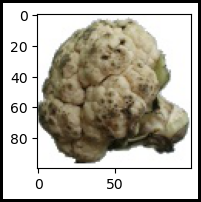

In [26]:
from matplotlib.image import imread
image = imread('/tmp/img')
plt.style.use('default')
plt.figure(figsize=(2, 2), edgecolor='black', linewidth=4)
plt.imshow(image)
plt.show()

### Calcul des features extraites

In [22]:
df_output = initialize_df_output()

img_path = '/tmp/img'
for img in tqdm_notebook(batch_img):
    s3_bucket.download_file('input/' + img, img_path)
    df_output = append_to_dataframe(df_output, VGG16_extracteur(img_path), img)

display(df_output.head())

  0%|          | 0/30 [00:00<?, ?it/s]

,dim_0,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7,dim_8,dim_9,dim_10,dim_11,dim_12,dim_13,dim_14,dim_15,dim_16,dim_17,dim_18,dim_19,dim_20,dim_21,dim_22,dim_23,dim_24,dim_25,dim_26,dim_27,dim_28,dim_29,dim_30,dim_31,dim_32,dim_33,dim_34,dim_35,dim_36,dim_37,dim_38,dim_39,dim_40,dim_41,dim_42,dim_43,dim_44,dim_45,dim_46,dim_47,dim_48,dim_49,dim_50,dim_51,dim_52,dim_53,dim_54,dim_55,dim_56,dim_57,dim_58,dim_59,dim_60,dim_61,dim_62,dim_63,dim_64,dim_65,dim_66,dim_67,dim_68,dim_69,dim_70,dim_71,dim_72,dim_73,dim_74,dim_75,dim_76,dim_77,dim_78,dim_79,dim_80,dim_81,dim_82,dim_83,dim_84,dim_85,dim_86,dim_87,dim_88,dim_89,dim_90,dim_91,dim_92,dim_93,dim_94,dim_95,dim_96,dim_97,dim_98,dim_99,...,dim_3997,dim_3998,dim_3999,dim_4000,dim_4001,dim_4002,dim_4003,dim_4004,dim_4005,dim_4006,dim_4007,dim_4008,dim_4009,dim_4010,dim_4011,dim_4012,dim_4013,dim_4014,dim_4015,dim_4016,dim_4017,dim_4018,dim_4019,dim_4020,dim_4021,dim_4022,dim_4023,dim_4024,dim_4025,dim_4026,dim_4027,dim_4028,dim_4029,dim_4030,dim_4031,dim_4032,dim_4033,dim_4034,dim_4035,dim_4036,dim_4037,dim_4038,dim_4039,dim_4040,dim_4041,dim_4042,dim_4043,dim_4044,dim_4045,dim_4046,dim_4047,dim_4048,dim_4049,dim_4050,dim_4051,dim_4052,dim_4053,dim_4054,dim_4055,dim_4056,dim_4057,dim_4058,dim_4059,dim_4060,dim_4061,dim_4062,dim_4063,dim_4064,dim_4065,dim_4066,dim_4067,dim_4068,dim_4069,dim_4070,dim_4071,dim_4072,dim_4073,dim_4074,dim_4075,dim_4076,dim_4077,dim_4078,dim_4079,dim_4080,dim_4081,dim_4082,dim_4083,dim_4084,dim_4085,dim_4086,dim_4087,dim_4088,dim_4089,dim_4090,dim_4091,dim_4092,dim_4093,dim_4094,dim_4095,path
0,0.0,0.0,0.0,2.363457,0.0,0.0,5.753050,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,2.822324,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,1.876393,0.0,0.0,2.378261,2.099965,2.944819,1.808272,0.000000,0.0,0.0,0.0,0.00000,0.0,2.592693,6.860825,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.685811,0.0,5.926198,0.0,0.132211,0.763508,0.0,0.787312,0.0,0.0,0.998741,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,1.538932,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,1.292179,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,1.885774,0.0,0.201606,2.174223,0.0,0.703131,0.0,0.0,0.000000,0.0,0.0,0.076951,0.0,0.0,0.0,4.658242,1.877420,0.000000,0.0,0.0,0.0,0.272653,0.351495,0.000000,4.478815,0.000000,3.266395,0.0,0.000000,0.0,0.182044,1.066797,0.0,3.427037,1.314594,0.0,0.0,2.192712,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.678623,0.0,0.0,4.613783,2.378513,1.860390,0.0,0.0,2.060694,2.910172,0.0,0.0,0.0,0.0,0.762518,0.0,3.374437,0.0,0.0,0.000000,0.000000,0.0,0.832530,0.0,0.0,0.0,3.016428,0.000000,2.997432,1.171421,0.0,0.0,0.000000,0.527215,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.106610,0.0,0.783764,0.0,0.000000,1.028740,0.000000,6.486232,0.000000,0.195561,0.0,Apple Braeburn/110_100.jpg
0,0.0,0.0,0.0,1.675637,0.0,0.0,6.319502,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,3.371343,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,1.557548,0.0,0.0,2.230097,2.812769,0.394682,1.712926,0.000000,0.0,0.0,0.0,0.00000,0.0,1.724589,6.778735,0.0,0.861946,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.861238,0.0,4.215691,0.0,0.653812,1.011819,0.0,0.837972,0.0,0.0,1.632736,0.0,0.286992,0.0,0.0,0.0,0.0,0.000000,0.0,1.644090,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,2.525231,0.0,0.0,1.533601,0.489774,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,1.203597,0.0,0.546456,2.303930,0.0,2.352643,0.0,0.0,0.000000,0.0,0.0,0.889428,0.0,0.0,0.0,3.556323,1.786728,0.000000,0.0,0.0,0.0,0.532855,1.157736,0.000000,3.921748,0.000000,2.784018,0.0,0.000000,0.0,1.484732,0.764266,0.0,3.084191,3.639465,0.0,0.0,1.730598,0.0,0.000000,0.0,0.754416,0.0,0.638119,1.433226,0.0,1.543279,0.0,0.0,5.564991,2.159027,0.938465,0.0,0.0,1.933760,2.951817,0.0,0.0,0.0,0.0,0.288732,0.0,2.335064,0.0,0.0,0.000000,0.958940,0.0,1.503114,0.0,0.0,0.0,3.631023,0.263251,2.902379,0.615064,0.0,0.0,0.000000,1.759595,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.03

In [23]:
# upload de df_output vers s3 via un fichier local
file_name = f'df_output_{len(df_output)}_fruits.csv'
local_path = os.path.join(dirpath, file_name)
df_output.to_csv(path_or_buf=local_path)
s3_bucket.upload_file(local_path, 'output/' + file_name)

# Réductions de dimension en local avec Spark

## Mise au point de l'extraction de features avec VGG16

### Démarrage d'un SparkContext

In [162]:
N_WORKERS = 3
conf = SparkConf()
conf.setMaster(f'local[{N_WORKERS}]').setAppName(f'Spark ({N_WORKERS} workers) sur Jupyter')
# conf.set("spark.python.profile", "false")
# conf.set("spark.driver.memory", "4g")
# conf.set("spark.executor.memory", "4g")

sc = SparkContext(conf=conf)

# broadcasting
inputpath = os.path.join(dirpath, 'input')
bc_inputpath = sc.broadcast(inputpath)
bc_model_vgg16 = sc.broadcast(model_vgg16)

INFO:tensorflow:Assets written to: ram://2a3a9458-06c8-48b7-a4a4-75ae10e1bb94/assets


In [163]:
sc.getConf().getAll()
# sc.getConf().get("spark.driver.memory")

[('spark.app.name', 'Spark (3 workers) sur Jupyter'),
 ('spark.driver.host', '192.168.1.24'),
 ('spark.rdd.compress', 'True'),
 ('spark.master', 'local[3]'),
 ('spark.driver.port', '41181'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.submit.pyFiles', ''),
 ('spark.app.startTime', '1642344132895'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.app.id', 'local-1642344132925'),
 ('spark.ui.showConsoleProgress', 'true')]

### Tests comparatifs d'extraction en variant le nb de workers / images 

In [97]:
# sans broadcast
# ancienne fonction (VGG16_extracteur_spark_old)
t0 = time()

N_IMAGES = 64

resultat = sc.parallelize(megabatch_img[:N_IMAGES]) \
    .map(lambda img: os.path.join(dirpath, 'input', img)) \
    .map(lambda img_path: VGG16_extracteur_spark_old(img_path)) \
    .collect()

t_delta = time() - t0

INFO:tensorflow:Assets written to: ram://93b5dc08-6a3f-475e-866a-c7f225e897fd/assets


22/01/16 11:12:33 ERROR TorrentBroadcast: Store broadcast broadcast_5 fail, remove all pieces of the broadcast


Py4JJavaError: An error occurred while calling o655.broadcast.
: java.lang.OutOfMemoryError: Java heap space


In [31]:
t_delta

23.28361678123474

Quelques remarques. Toutes choses égales par ailleurs :  
    - le premier run après un chargement de nouveau spark context est plus long que le runs suivants.  
    - les temps indiqués ci-dessous sont les temps mesurés pour la durée d'exécution de la cellule Jupyter avec la nbextension ExecuteTime (ExecuteTime retourne 6s de plus que les temps de Spark Web UI pour 4 workers).

__1 worker :__  
1 worker et 1 image : 2 runs : 10.5 / 10.9s   
1 worker et 64 images : 2 runs : 20.8 / 21.2s  
1 worker et 2048 images : le job plante à chaque fois (3 tests) après environ 345s : "java.lang.OutOfMemoryError: Java heap space" (solution ? lorsque Java est démarré il faut certainement lui donner un heap plus grand).    
En résumé, avec 1 worker :  il faut 10.5s d'overhead puis 10.5s pour 64 images.  
Durant les jobs longs, la RAM (32Go au total) monte de 15% (initial) à 26% d'utilisation, les CPU sont à 60%. 

__2 workers :__  
2 workers et 1 image : 11.0 / 10.6s  
2 workers et 4 images : 11.6 / 11.2  
2 workers et 16 images : 12.7 / 13.1  
2 workers et 64 images : 20.0 / 19.8  
2 workers et 128 images : 28.7 / 29.3  
2 workers et 2048 images : 300 / 304s  
En résumé, avec 2 workers :  il faut 11s d'overhead puis 9s pour 64 images.  
Durant les jobs longs, la RAM (32Go au total) monte de 15% (initial) à 35% d'utilisation, les CPU sont à 75%.  
  
__4 workers :__  
4 workers et 1 image : 14.4 / 12.8 / 13.3s  
4 workers et 16 images : 15.9 / 14.3  
4 workers et 64 images : 20.9 / 21.3  
4 workers et 128 images : 28.9 / 28.9  
4 workers et 256 images : 46.1 / 44.5  
4 workers et 512 images : 76.3 / 77.2
4 workers et 2048 images :  277 / 270  
En résumé, avec 4 workers :  il faut 13s d'overhead puis 8s pour 64 images.  
Durant les jobs longs, la RAM (32Go au total) monte de 15% (initial) à 60% d'utilisation (pic à 80%), les CPU sont à 95%.  

__8 workers :__  
J'ai fait un premier test avec 8 workers, mais mes applis ouvertes et le système (carte réseau !) ont été bousillées par le job Spark. Le problème vient de l'insuffisance de la RAM (solution : augmenter le swap ?).  
Les tests suivants ont été réalisés avec Jupyter fermé (uniquement avec le kernel ipython ouvert), et le monitoring s'est fait avec time.time()
8 workers et 1 image : 20.7 / 19.0s (CPU, RAM et swap à 100%!)
8 workers et 64 images : plantage "ERROR Executor" "org.apache.spark.SparkException: Python worker exited unexpectedly (crashed)", c'est sans doute dû à un manque de RAM, mais ce n'est pas dit explicitement dans les logs. Cependant Java n'a pas planté (on peut lancer des runs subséquents).  
En augmentant le swap de mon système (de 2Go à 16Go), la RAM tient, mais on ça plante sur une "java.lang.OutOfMemoryError: Java heap space".  
En passant conf.set("spark.driver.memory", "4g") et conf.set("spark.executor.memory", "4g") : a priori ça n'a pas d'effet sur "heap committed" de la JVM, et on se retrouve encore avec une "java.lang.OutOfMemoryError: Java heap space".  
Différents essais pour augmenter la heap de java : non concluant.  
Autres solutions envisagées : rendre le GC de Python plus agressif.

In [32]:
resultat[0] # liste de listes

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 7.7074408531188965,
 0.0,
 0.0,
 0.0,
 0.20626631379127502,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.816618025302887,
 0.0,
 0.0,
 0.0,
 0.0,
 4.550092697143555,
 3.883251667022705,
 2.0262532234191895,
 0.4661981463432312,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 2.3623247146606445,
 8.67631721496582,
 0.0,
 2.6315195560455322,
 0.0,
 0.4081782400608063,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 2.013054847717285,
 0.0,
 4.89426851272583,
 0.0,
 0.0,
 0.0,
 0.0,
 2.7911455631256104,
 0.5568380355834961,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.1156386137008667,
 0.0,
 0.0,
 0.0,
 0.04692184925079346,
 0.0,
 0.0,
 0.0,
 0.0,
 3.428859233856201,
 0.0,
 0.0,
 3.2263593673706055,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 6.155905723571777,
 1.0171427726745605,
 0.0,
 5.503293037414551,
 

In [33]:
# conversion du résultat en dataframe : c'est inélégant mais c'est quick and dirty. La méthode élégante de Spark est très très lente.
pd.DataFrame(resultat)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,...,3997,3998,3999,4000,4001,4002,4003,4004,4005,4006,4007,4008,4009,4010,4011,4012,4013,4014,4015,4016,4017,4018,4019,4020,4021,4022,4023,4024,4025,4026,4027,4028,4029,4030,4031,4032,4033,4034,4035,4036,4037,4038,4039,4040,4041,4042,4043,4044,4045,4046,4047,4048,4049,4050,4051,4052,4053,4054,4055,4056,4057,4058,4059,4060,4061,4062,4063,4064,4065,4066,4067,4068,4069,4070,4071,4072,4073,4074,4075,4076,4077,4078,4079,4080,4081,4082,4083,4084,4085,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095,4096
0,0.0,0.0,0.0,0.000000,0.0,0.0,7.707441,0.0,0.0,0.0,0.206266,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.816618,0.0,0.000000,0.0,0.0,4.550093,3.883252,2.026253,0.466198,0.0,0.0,0.0,0.0,0.000000,0.0,2.362325,8.676317,0.0,2.631520,0.0,0.408178,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,2.013055,0.0,4.894269,0.0,0.000000,0.000000,0.0,2.791146,0.556838,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,1.115639,0.0,0.0,0.0,0.046922,0.0,0.0,0.0,0.0,3.428859,0.0,0.0,3.226359,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.000000,2.884597,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,7.052611,0.244668,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,3.617068,0.000000,2.405460,0.0,0.0,0.0,2.156476,1.976058,0.0,5.916897,0.631698,0.0,0.0,0.000000,0.0,3.189957,0.0,0.000000,0.0,0.000000,1.533861,0.0,3.382357,0.0,0.0,8.087277,4.379069,1.486007,0.0,0.000000,1.597373,4.910885,0.0,0.0,0.0,0.0,2.001862,0.0,5.759781,0.000000,0.0,1.496690,0.389178,0.0,1.216434,0.0,0.0,0.0,4.726130,0.000000,2.063915,0.368923,0.0,0.0,1.067489,2.895292,0.0,0.000000,0.0,0.0,0.0,1.353366,0.0,0.896135,0.000000,0.000000,0.0,1.189075,0.940704,0.000000,3.395599,0.258411,1.812143,0.0,/home/jim/projet8/input/Apple Braeburn/0_100.jpg
1,0.0,0.0,0.0,1.860840,0.0,0.0,6.156754,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.806051,0.0,0.217776,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,1.398380,0.0,0.0,3.199074,1.177544,3.198128,1.349004,0.0,0.0,0.0,0.0,0.000000,0.0,2.409420,6.927776,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,2.793934,0.0,5.099166,0.0,0.000000,0.643207,0.0,1.985424,0.000000,0.0,0.174190,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,1.027437,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.725479,0.0,0.0,1.276844,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.000000,2.622023,0.0,0.453475,1.895137,0.0,0.929288,0.0,0.0,0.0,0.0,0.0,0.787319,0.0,0.0,0.0,4.740570,0.327348,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,3.757421,0.000000,3.416483,0.0,0.0,0.0,1.224864,0.139760,0.0,4.121590,0.486959,0.0,0.0,0.418386,0.0,0.000000,0.0,0.000000,0.0,0.508059,0.000000,0.0,1.320193,0.0,0.0,5.536570,2.623335,2.039081,0.0,0.000000,1.725121,2.202492,0.0,0.0,0.0,0.0,0.483148,0.0,5.102570,0.000000,0.0,0.000000,0.000000,0.0,0.794047,0.0,0.0,0.0,2.813943,0.000000,2.177522,1.616907,0.0,0.0,0.000000,0.712589,0.0,0.000000,0.0,0.0,0.0,1.635243,0.0,0.000000,0.000000,0.500092,0.0,0.000000,0.772667,0.000000,5.774759,0.000000,1.141268,0.0,/home/jim/projet8/input/Apple Braeburn/100_100...
2,0.0,0.0,0.0,2.629139,0.0,0.0,5.248846,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.821226,0.0,0.470394,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,1.575772,0.0,0.0,2.734586,2.083381,3.096009,1.044707,0.0,0.0,0.0,0.0,0.000000,0.0,2.450673,6.867932,0.0,0.000000,0.0,0.720028,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,3.570729,0.0,5.327178,0.0,0.000000,0.422213,0.0,1.460718,0.000000,0.0,0.454584,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,1.032614,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.882505,0.0,0.0,1.121398,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.019309,2.230621,0.0,0.459137,1.854

In [34]:
resultat = [0]

### Utilisation de broadcast (données chargées en local)

In [96]:
t0 = time()

N_IMAGES = 64

resultat = sc.parallelize(megabatch_img[:N_IMAGES]) \
    .map(lambda img: VGG16_extracteur_spark(bc_inputpath.value, img, bc_model_vgg16.value)) \
    .collect()

t_delta = time() - t0

Temps de calcul :  
  
| SETUP                        | SANS BRODCAST |            AVEC BROADCAST  | 
| ---------------------------- | ------------- | ----------------------------  |
| 1 workers / 64 images     | 21s |  16.6 / 11.0 / 10.7s / 15.2 / 10.6 / 11.2 / 10.6 / 10.6s  |
| 2 workers / 1 images     | 10.7s | 0.2 / 0.2 / 0.2 / 2.4 / 2.4 / 0.2 / 0.2 / 2.1 / 0.2s  |
| 2 workers / 16 images     |12.9s |  8.5 / 6.5 / 2.5 / 6.3 / 2.2 / 4.6s  |
| 2 workers / 64 images     | 19.9s | 13.5 / 9.0 /  9.7s  | 
| 2 workers / 128 images     | 29.0s | 18.1 / 18.4s  |
| 2 workers / 2048 images     | 300s | planté (heap space) / 291s / 292s  | 
| 4 workers / 64 images     | 21s | 16.5 / 8.5 / 8.3 / 8.5s  | 
| 8 workers / 64 images     |  | 8.3 / 8.4 / 8.8s  | 
  
En résumé, avec 2 workers :  il faut 0s d'overhead puis 9s pour 64 images.  
Durant les jobs longs, la RAM (32Go au total) monte de ?% (initial) à 22% d'utilisation, les CPU sont à 75%.  

1 worker : CPUs à 65%  
2 workers : CPUs à 75%  
4 workers : CPUs à 95%  
8 workers : CPUs à 100%


Le boost en temps d'overhead est spectaculaire ! Mais les résultats sont assez fluctuants, en particulier lorsque N_IMAGES est petit.   
Typiquement, quand on fait le calcul d'un même setup plusieurs fois d'affilée, le premier run (parfois le second) est plus lent.  
Au global, le gain est faible sur un grand nombre d'image.  
  


### Les données sont téléchargées depuis S3

In [133]:
# logger
logfile = "Log for job started " + timestamp() + ".txt"
logger_s3(s3_bucket, logfile, "job starts")

In [134]:
N_IMAGES = 16

resultat = sc.parallelize(megabatch_img[:N_IMAGES]) \
    .map(lambda img: VGG16_extracteur_spark('S3', img, bc_model_vgg16.value)) \
    .collect()

2022-01-16 12:33:45.472792: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-16 12:33:45.472911: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-01-16 12:33:45.477626: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-16 12:33:45.477851: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-01-16 12:33:45.493672: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or dire

2022-01-16 12:33:50.533851: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-16 12:33:50.534815: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-16 12:33:50.535551: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-01-16 12:33:50.535883: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-01-16 12:33:50.536188: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

2022-01-16 12:33:51.488255: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-16 12:33:51.491969: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-16 12:33:51.497494: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-01-16 12:33:51.498434: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-01-16 12:33:51.500132: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

Temps de calcul :  
  
| SETUP                        |         INPUT DATA EN LOCAL  | INPUT DATA SUR S3 |
| ---------------------------- |  ----------------------------  |-------------  |
| 1 worker / 64 images     | 13s  | 30.6 / 26.3 / 27.4 / 30.0 / 26.6 / 25.9 / 30.2 s|
| 2 workers / 1 images     |  0.2s  | 0.5 / 0.4 / 0.4s |
| 2 workers / 16 images     |  2.2s  | 4.2 / 8.2 / 4.2 / 4.3s | 
| 2 workers / 64 images     | 9.0s  | 16.6 / 16.4 s|
| 2 workers / 128 images     | 18.2s  | 31.0 / 31.9 s |
| 2 workers / 2048 images     | 291s / 292s  | 515s |
| 4 workers / 64 images     | 8.5s  | 11.2 / 11.1 / 10.9 s|
| 8 workers / 64 images     |  8.5s | 9.5 / 9.3 / 9.0 / 9.2  s|
  
En résumé, avec 2 workers :  il faut 0s d'overhead puis 16s pour 64 images.  
Durant les jobs longs, la RAM (32Go au total) monte de ?% (initial) à 38% d'utilisation.
Le temps de calcul augmente de 80% par rapport au chargement local de la data.  

1 worker : CPUs à 30%.  
2 worker : CPUs à 50%.  
4 workers : CPUs à 75%.  
8 workers : CPUs à 95%

In [135]:
# logger
logger_s3(s3_bucket, logfile, "job has finished")

### Export du résultat vers S3

In [153]:
df_output = pd.DataFrame(resultat)
df_output.columns = [f'dim_{i}' for i in range(4096)] + ['path']

df_output

,dim_0,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7,dim_8,dim_9,dim_10,dim_11,dim_12,dim_13,dim_14,dim_15,dim_16,dim_17,dim_18,dim_19,dim_20,dim_21,dim_22,dim_23,dim_24,dim_25,dim_26,dim_27,dim_28,dim_29,dim_30,dim_31,dim_32,dim_33,dim_34,dim_35,dim_36,dim_37,dim_38,dim_39,dim_40,dim_41,dim_42,dim_43,dim_44,dim_45,dim_46,dim_47,dim_48,dim_49,dim_50,dim_51,dim_52,dim_53,dim_54,dim_55,dim_56,dim_57,dim_58,dim_59,dim_60,dim_61,dim_62,dim_63,dim_64,dim_65,dim_66,dim_67,dim_68,dim_69,dim_70,dim_71,dim_72,dim_73,dim_74,dim_75,dim_76,dim_77,dim_78,dim_79,dim_80,dim_81,dim_82,dim_83,dim_84,dim_85,dim_86,dim_87,dim_88,dim_89,dim_90,dim_91,dim_92,dim_93,dim_94,dim_95,dim_96,dim_97,dim_98,dim_99,...,dim_3997,dim_3998,dim_3999,dim_4000,dim_4001,dim_4002,dim_4003,dim_4004,dim_4005,dim_4006,dim_4007,dim_4008,dim_4009,dim_4010,dim_4011,dim_4012,dim_4013,dim_4014,dim_4015,dim_4016,dim_4017,dim_4018,dim_4019,dim_4020,dim_4021,dim_4022,dim_4023,dim_4024,dim_4025,dim_4026,dim_4027,dim_4028,dim_4029,dim_4030,dim_4031,dim_4032,dim_4033,dim_4034,dim_4035,dim_4036,dim_4037,dim_4038,dim_4039,dim_4040,dim_4041,dim_4042,dim_4043,dim_4044,dim_4045,dim_4046,dim_4047,dim_4048,dim_4049,dim_4050,dim_4051,dim_4052,dim_4053,dim_4054,dim_4055,dim_4056,dim_4057,dim_4058,dim_4059,dim_4060,dim_4061,dim_4062,dim_4063,dim_4064,dim_4065,dim_4066,dim_4067,dim_4068,dim_4069,dim_4070,dim_4071,dim_4072,dim_4073,dim_4074,dim_4075,dim_4076,dim_4077,dim_4078,dim_4079,dim_4080,dim_4081,dim_4082,dim_4083,dim_4084,dim_4085,dim_4086,dim_4087,dim_4088,dim_4089,dim_4090,dim_4091,dim_4092,dim_4093,dim_4094,dim_4095,path
0,0.0,0.000000,0.000000,2.363457,0.000000,0.000000,5.753050,0.00000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,2.822324,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.876393,0.000000,0.000000,2.378261,2.099965,2.944819,1.808272,0.000000,0.0,0.000000,0.0,0.000000,0.000000,2.592693,6.860825,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,3.685811,0.000000,5.926198,0.0,0.132211,0.763508,0.0,0.787312,0.000000,0.0,0.998741,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.538932,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,1.292179,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,1.885774,0.000000,0.201606,2.174223,0.0,0.703131,0.000000,0.0,0.000000,0.000000,0.000000,0.076951,0.000000,0.000000,0.000000,4.658242,1.877420,0.000000,0.000000,0.000000,0.0,0.272653,0.351495,0.000000,4.478815,0.000000,3.266395,0.0,0.000000,0.000000,0.182044,1.066797,0.000000,3.427037,1.314594,0.0,0.0,2.192712,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.678623,0.0,0.0,4.613783,2.378513,1.860390,0.000000,0.000000,2.060694,2.910172,0.0,0.0,0.000000,0.0,0.762518,0.0,3.374437,0.000000,0.000000,0.000000,0.000000,0.0,0.832530,0.000000,0.000000,0.0,3.016428,0.000000,2.997432,1.171421,0.000000,0.0,0.000000,0.527215,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.106610,0.000000,0.783764,0.0,0.000000,1.028740,0.000000,6.486232,0.000000,0.195561,0.000000,Apple Braeburn/110_100.jpg
1,0.0,0.000000,0.000000,1.675637,0.000000,0.000000,6.319502,0.00000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,3.371343,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.557548,0.000000,0.000000,2.230097,2.812769,0.394682,1.712926,0.000000,0.0,0.000000,0.0,0.000000,0.000000,1.724589,6.778735,0.0,0.861946,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,2.861238,0.000000,4.215691,0.0,0.653812,1.011819,0.0,0.837972,0.000000,0.0,1.632736,0.000000,0.286992,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.644090,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,2.525231,0.000000,0.0,1.533601,0.489774,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,1.203597,0.000000,0.546456,2.303930,0.0,2.

In [38]:
# upload de df_output vers s3 via un fichier local (le précédent fichier du même nom est écrasé mais une version est conservée)
s3_bucket = boto3.resource('s3').Bucket('oc-projet-8')
file_name = f'df_output_{len(df_output)}_fruits_-_spark_en_local.csv'
local_path = os.path.join(dirpath, file_name)
df_output.to_csv(path_or_buf=local_path)
s3_bucket.upload_file(local_path, 'output/' + file_name)

### Arrêt du SparkContext

In [140]:
bc_inputpath.unpersist()
bc_model_vgg16.unpersist()
sc.stop()

## Conversion du RDD post-extraction en dataframe spark

Le but est de récupérer le RDD issu de l'extraction, avant le collect(), pour le transmettre à un spark.createDataFrame(rdd).  
  
Mais ça ne fonctionne pas avec spark.createDataFrame(rdd)  
Officiellement : "java.lang.OutOfMemoryError: Java heap space" mais pourtant les jobs démarrés (1 image) ne requièrent que peu de mémoire.   

Avec rdd.toDF() : ça fonctionne mais c'est très lent.  

### Echecs avec spark.createDataFrame(rdd)

Il faut choisir une deux options suivantes : scratch ou réactivation.  
Seule la deuxièmes fonctionne sans bug.  

#### Démarrage d'une SparkSession partir d'un SparkContext

In [154]:
N_WORKERS = 2

from pyspark import SparkContext
sc = SparkContext(f'local[{N_WORKERS}]', f'Spark ({N_WORKERS} workers) sur Jupyter')

bc_dirpath = sc.broadcast(dirpath)

In [155]:
from pyspark.sql import SparkSession
spark = SparkSession(sc)

###### Calculs

In [156]:
rdd = sc.parallelize(megabatch_img[:16]) \
    .map(lambda img: os.path.join(bc_dirpath.value, 'input', img)) \
    .map(lambda img_path: VGG16_extracteur_spark(img_path))

In [157]:
resultat_intermediaire = rdd.collect()

INFO:tensorflow:Assets written to: ram://246e56e4-493d-40be-8df5-0bd6e9b90592/assets


2022-01-14 12:07:09.412375: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-14 12:07:09.412403: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-01-14 12:07:09.427528: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-14 12:07:09.427573: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-01-14 12:07:11.718663: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022

Jusqu'ici tout fonctionne.

In [158]:
sdf = spark.createDataFrame(rdd)

INFO:tensorflow:Assets written to: ram://d3fb010e-ad88-450f-b77b-e2fb000adca6/assets


22/01/14 12:07:33 ERROR TorrentBroadcast: Store broadcast broadcast_3 fail, remove all pieces of the broadcast


Py4JJavaError: An error occurred while calling o814.broadcast.
: java.lang.OutOfMemoryError: Java heap space


La création de la SparkSession fonctionne mais :  
il y a un bug lorsqu'on essaie de passer le RDD créé par le SparkContext au DataFrame créé par la SparkSession.  
"java.lang.OutOfMemoryError: Java heap space"

#### Démarrage d'une SparkSession from scratch

In [26]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master("local") \
    .appName("Extraction VGG16") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [27]:
spark

###### Calculs

In [28]:
rdd = spark.sparkContext.parallelize(megabatch_img[:16]).map(lambda img: os.path.join("/home/jim/projet8/input", img)).map(lambda img_path: VGG16_extracteur_spark(img_path))
rdd.collect()

INFO:tensorflow:Assets written to: ram://78ecf902-7086-4e74-91e5-f1d1828a060e/assets


2022-01-14 14:46:57.521825: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-14 14:46:57.521853: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-01-14 14:46:59.671556: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-14 14:46:59.671885: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-14 14:46:59.671965: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.s

[[0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  7.7074408531188965,
  0.0,
  0.0,
  0.0,
  0.20626631379127502,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.816618025302887,
  0.0,
  0.0,
  0.0,
  0.0,
  4.550092697143555,
  3.883251667022705,
  2.0262532234191895,
  0.4661981463432312,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  2.3623247146606445,
  8.67631721496582,
  0.0,
  2.6315195560455322,
  0.0,
  0.4081782400608063,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  2.013054847717285,
  0.0,
  4.89426851272583,
  0.0,
  0.0,
  0.0,
  0.0,
  2.7911455631256104,
  0.5568380355834961,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.1156386137008667,
  0.0,
  0.0,
  0.0,
  0.04692184925079346,
  0.0,
  0.0,
  0.0,
  0.0,
  3.428859233856201,
  0.0,
  0.0,
  3.2263593673706055,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
 

In [29]:
sdf = spark.createDataFrame(rdd)

INFO:tensorflow:Assets written to: ram://17805253-d7bc-4e0a-b707-8dc70b7b92e3/assets


22/01/14 14:47:14 ERROR TorrentBroadcast: Store broadcast broadcast_2 fail, remove all pieces of the broadcast


Py4JJavaError: An error occurred while calling o107.broadcast.
: java.lang.OutOfMemoryError: Java heap space


In [21]:
sdf.show()

22/01/14 14:36:29 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
2022-01-14 14:36:35.037184: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-14 14:36:35.037241: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-01-14 14:36:37.784891: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-14 14:36:37.785231: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such 

+---+---+---+------------------+---+---+------------------+---+---+---+-------------------+---+---+---+---+------------------+---+-------------------+---+-------------------+---+---+---+---+---+---+---+---+---+---+---+---+---+------------------+---+------------------+---+---+------------------+------------------+------------------+------------------+---+---+---+---+-------------------+---+------------------+------------------+---+-------------------+---+-------------------+---+---+---+---+---+---+---+------------------+---+------------------+---+-------------------+-------------------+---+------------------+------------------+---+-------------------+---+---+------------------+---+---+--------------------+---+---+------------------+---+---+---+--------------------+---+---+---+---+------------------+---+---+-------------------+---+-------------------+---+---+---+---+-------------------+----+-------------------+----+----+----+----+----+----+----+------------------+------------------+----+

#### Tentatives de résolution du bug "java.lang.OutOfMemoryError: Java heap space"

https://sparkbyexamples.com/spark/java-io-ioexception-org-apache-spark-sparkexception-failed-to-get-broadcast_50_piece0-of-broadcast_50/  
  
While running spark jobs, you may come across java.io.IOException: org.apache.spark.SparkException: Failed to get broadcast_0_piece0 of broadcast_0 error with below stack trace. This error occurs when you try to create multiple spark contexts.  
  
Ideally we should not create multiple spark context’s. Some times unknowingly, our code might cause to create multiple spark context and this would be very hard to trouble shoot and fix. some cases the code might work in standalone and fails on cluster. So carefully refactor the code not to create multiple spark context’s.

Cependant, après redémarrage du PC, re-run des cellules avec une unique création de spark context et examen de mon code, il me semble impossible que je traine deux spark contexts. En effet, mon code "rdd = spark.sparkContext.parallelize(..." utilise l'attribut .sparkContext qui ne fait qu'appeler le spark context déjà existant.  
  
Mon erreur est une "java.lang.OutOfMemoryError: Java heap space"  

___

https://stackoverflow.com/questions/32336915/pyspark-java-lang-outofmemoryerror-java-heap-space  
  
After trying out loads of configuration parameters, I found that there is only one need to be changed to enable more Heap space and i.e. spark.driver.memory.  
sudo vim $SPARK_HOME/conf/spark-defaults.conf  
#uncomment the spark.driver.memory and change it according to your use. I changed it to below  
spark.driver.memory 15g  
Close your existing spark application and re run it. You will not encounter this error again. :)  
  
From docs: spark.driver.memory "Amount of memory to use for the driver process, i.e. where SparkContext is initialized. (e.g. 1g, 2g). Note: In client mode, this config must not be set through the SparkConf directly in your application, because the driver JVM has already started at that point. Instead, please set this through the --driver-memory command line option or in your default properties file."    
___
  
You can verify that the JVM is using the increased Java heap space:  
Open a terminal window. Enter the following command: ps -ef | grep java | grep Xmx  
Xmx est la valeur max de la heap de la JVM  

### Par un calcul tout-en-un avec .toDF(), ça fonctionne mais c'est très lent

In [55]:
# Il faut une SparkSession sinon c'est la merde, même si la doc Spark dit autrement.  Le spark.sparkContext "hérite" alors de la SparkSession.
# !!!!!!!!!!!!!!!!!!! Utiliser cette méthode pour appeler un Spark Context : spark.sparkContext

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('SparkByExamples.com').getOrCreate()

In [53]:
sdf = spark.sparkContext.parallelize(megabatch_img[:4]) \
    .map(lambda img: os.path.join("/home/jim/projet8/input", img)) \
    .map(lambda img_path: VGG16_extracteur_spark(img_path)) \
    .toDF()

INFO:tensorflow:Assets written to: ram://83ff21ec-1dd8-48e2-83ef-fb3cb35b2860/assets


2022-01-14 16:35:54.337697: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-14 16:35:54.337743: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-01-14 16:35:57.621846: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-14 16:35:57.622307: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-14 16:35:57.622434: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.s

INFO:tensorflow:Assets written to: ram://68d7ca47-9fcc-4142-8d28-d05d920348d9/assets


2022-01-14 16:36:07.497793: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-14 16:36:07.497835: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-01-14 16:36:07.499748: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-14 16:36:07.499759: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-14 16:36:07.499789: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your mac

INFO:tensorflow:Assets written to: ram://7b571aa7-eb21-4ab9-b940-830ac287eeec/assets


En remplaçant .collect() par .toDF(), le temps de calcul triple => on préférera travailler avec .collect() qu'avec .toDF()

In [ ]:
### Par un calcul tout-en-un avec .toDF(), ça fonctionne mais c'est très lent

# Il faut une SparkSession sinon c'est la merde, même si la doc Spark dit autrement.  Le spark.sparkContext "hérite" alors de la SparkSession.
# !!!!!!!!!!!!!!!!!!! Utiliser cette méthode pour appeler un Spark Context : spark.sparkContext

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('SparkByExamples.com').getOrCreate()

sdf = spark.sparkContext.parallelize(megabatch_img[:4]) \
    .map(lambda img: os.path.join("/home/jim/projet8/input", img)) \
    .map(lambda img_path: VGG16_extracteur_spark(img_path)) \
    .toDF()

En remplaçant .collect() par .toDF(), le temps de calcul triple => on préférera travailler avec .collect() qu'avec .toDF()

### Arrêt de la SparkSession

In [78]:
spark.stop()

## Lancement du job complet depuis la CLI avec la commande spark-submit

### v1

Le code de la cellule suivante est copié dans le fichier "extraction_features_v1.py"  

Durée du job spark avec la commande "spark-submit --master __local[4]__ extraction_features_v1.py" :   
 4 images : 9.7 / 9.5 / 9.6s  (durée totale du script Python : 19 / 19s)  
16 images : 11.5 / 11.9 / 11.5s  
64 images : 20.2 / 19.3s
128 images : 29.8 / 26.9s / 31.6 / 28.6s (durée totale du script Python : 42 / 39s)  
=> Il y a un overhead de 10s pour le démarrage et l'export des données.  
Les CPUs turbinent à 85%.  

Durée du job spark avec la commande "spark-submit --master __local[8]__ extraction_features_v1.py" :   
128 images : 30.4 / 32.2s (durée totale du script Python : 39 / 42s)  
La RAM monte à 100% (32Go) et le swap prend le relai (5% de 16Go).  
Les CPUs turbinent à 95%.  

In [174]:
# imports modules
import numpy as np
import pandas as pd
import os
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import VGG16
from keras.models import Model
from pyspark import SparkContext
import boto3
from datetime import datetime
from time import time

def timestamp():
    return datetime.now().strftime("%Y-%m-%d--%H-%M-%S")

def logger_s3(s3_bucket, logfile, log, log_to_shell=True):
    """Appends log to logfile. Uploads each update to S3 bucket.
    Args :
        - s3_bucket (Bucket).
        - logfile (string) .
        - log (string).
        - log_to_shell (bool) : si True, imprime également dans le std.out.
    Returns : /
    """
    time_log = timestamp() + " : " + log + "\n"
    if log_to_shell : print("*"*100 + "\n", time_log)
    with open("./logs/"+ logfile, 'a') as f:
        f.write(time_log)
    s3_bucket.upload_file("./logs/"+ logfile, 'logs/' + logfile)

# fonction d'extraction de feature
def VGG16_extracteur_spark(path, nom_image, model):
    """Transforme un fichier image en un vecteur de dimension 4096.
    Args :
    - path : chemin vers les images (chemin local ou 'S3').
    - nom_image : chemin d'accès à l'image (exemple : 'Apple Braeburn/r_173_100.jpg')
    - model : model_vgg16 ou bc_model_vgg16.
    Returns :
    - liste de dimension 4097 (4096 dimensions de VGG16 + nom_image).
    """
    # create path to the image stored locally
    if path == 'S3':
        s3_bucket_vgg16 = boto3.resource('s3').Bucket('oc-projet-8')    # il faut un une instance Bucket différente sur le driver et les exécuteurs
        s3_bucket_vgg16.download_file('input/' + nom_image, '/tmp/img')
        path_nom_image = '/tmp/img'
    else:
        path_nom_image = os.path.join(path, nom_image)
    # load the image for keras processing
    image = load_img(path_nom_image, target_size=(224, 224))
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    # reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # prepare the image for the VGG model
    image = preprocess_input(image)
    # get extracted features
    im_features = model.predict(image)
    # convert to list and add nom_image
    im_features = im_features[0].tolist()
    im_features.append(nom_image)
    return im_features

# if __name__ == '__main__':  # tester si ça marche avec cette ligne ?

# il faut un une instance Bucket différente sur le driver et les exécuteurs
s3_bucket = boto3.resource('s3').Bucket('oc-projet-8')

# start logging
os.makedirs(os.path.join(os.getcwd(), 'logs/'), exist_ok=True)
logfile = "Log for job started " + timestamp() + ".txt"
logger_s3(s3_bucket, logfile, "logging starts")

# load model VGG16
model_vgg16 = VGG16()
# remove the output layer
model_vgg16 = Model(inputs=model_vgg16.inputs, outputs=model_vgg16.layers[-2].output)

# Spark context : le SparkConf est supprimé car géré via le spark-submit
sc = SparkContext()

# logger des paramètres du spark context lancé
logger_s3(s3_bucket, logfile, "Configuration de Spark :" + str(sc.getConf().getAll()))



# broadcasting
bc_model_vgg16 = sc.broadcast(model_vgg16)




# liste des images pour le test
batch_img = \
['Apple Braeburn/0_100.jpg',
 'Apple Braeburn/100_100.jpg',
 'Apple Braeburn/101_100.jpg',
 'Apple Braeburn/102_100.jpg',
 'Apple Braeburn/103_100.jpg',
 'Apple Braeburn/104_100.jpg',
 'Apple Braeburn/105_100.jpg',
 'Apple Braeburn/106_100.jpg',
 'Apple Braeburn/107_100.jpg',
 'Apple Braeburn/108_100.jpg',
 'Apple Braeburn/109_100.jpg',
 'Apple Braeburn/10_100.jpg',
 'Apple Braeburn/110_100.jpg',
 'Apple Braeburn/111_100.jpg',
 'Apple Braeburn/112_100.jpg',
 'Apple Braeburn/113_100.jpg',
 'Apple Braeburn/114_100.jpg',
 'Apple Braeburn/115_100.jpg',
 'Apple Braeburn/116_100.jpg',
 'Apple Braeburn/117_100.jpg',
 'Apple Braeburn/118_100.jpg',
 'Apple Braeburn/119_100.jpg',
 'Apple Braeburn/11_100.jpg',
 'Apple Braeburn/120_100.jpg',
 'Apple Braeburn/121_100.jpg',
 'Apple Braeburn/122_100.jpg',
 'Apple Braeburn/123_100.jpg',
 'Apple Braeburn/124_100.jpg',
 'Apple Braeburn/125_100.jpg',
 'Apple Braeburn/126_100.jpg',
 'Apple Braeburn/127_100.jpg',
 'Apple Braeburn/128_100.jpg',
 'Apple Braeburn/129_100.jpg',
 'Apple Braeburn/12_100.jpg',
 'Apple Braeburn/130_100.jpg',
 'Apple Braeburn/131_100.jpg',
 'Apple Braeburn/132_100.jpg',
 'Apple Braeburn/133_100.jpg',
 'Apple Braeburn/134_100.jpg',
 'Apple Braeburn/135_100.jpg',
 'Apple Braeburn/136_100.jpg',
 'Apple Braeburn/137_100.jpg',
 'Apple Braeburn/138_100.jpg',
 'Apple Braeburn/139_100.jpg',
 'Apple Braeburn/13_100.jpg',
 'Apple Braeburn/140_100.jpg',
 'Apple Braeburn/141_100.jpg',
 'Apple Braeburn/142_100.jpg',
 'Apple Braeburn/143_100.jpg',
 'Apple Braeburn/144_100.jpg',
 'Apple Braeburn/145_100.jpg',
 'Apple Braeburn/146_100.jpg',
 'Apple Braeburn/147_100.jpg',
 'Apple Braeburn/148_100.jpg',
 'Apple Braeburn/149_100.jpg',
 'Apple Braeburn/14_100.jpg',
 'Apple Braeburn/150_100.jpg',
 'Apple Braeburn/151_100.jpg',
 'Apple Braeburn/152_100.jpg',
 'Apple Braeburn/153_100.jpg',
 'Apple Braeburn/154_100.jpg',
 'Apple Braeburn/155_100.jpg',
 'Apple Braeburn/156_100.jpg',
 'Apple Braeburn/157_100.jpg',
 'Apple Braeburn/158_100.jpg',
 'Apple Braeburn/159_100.jpg',
 'Apple Braeburn/15_100.jpg',
 'Apple Braeburn/160_100.jpg',
 'Apple Braeburn/161_100.jpg',
 'Apple Braeburn/162_100.jpg',
 'Apple Braeburn/163_100.jpg',
 'Apple Braeburn/164_100.jpg',
 'Apple Braeburn/165_100.jpg',
 'Apple Braeburn/166_100.jpg',
 'Apple Braeburn/167_100.jpg',
 'Apple Braeburn/168_100.jpg',
 'Apple Braeburn/169_100.jpg',
 'Apple Braeburn/16_100.jpg',
 'Apple Braeburn/170_100.jpg',
 'Apple Braeburn/171_100.jpg',
 'Apple Braeburn/172_100.jpg',
 'Apple Braeburn/173_100.jpg',
 'Apple Braeburn/174_100.jpg',
 'Apple Braeburn/175_100.jpg',
 'Apple Braeburn/176_100.jpg',
 'Apple Braeburn/177_100.jpg',
 'Apple Braeburn/178_100.jpg',
 'Apple Braeburn/179_100.jpg',
 'Apple Braeburn/17_100.jpg',
 'Apple Braeburn/180_100.jpg',
 'Apple Braeburn/181_100.jpg',
 'Apple Braeburn/182_100.jpg',
 'Apple Braeburn/183_100.jpg',
 'Apple Braeburn/184_100.jpg',
 'Apple Braeburn/185_100.jpg',
 'Apple Braeburn/186_100.jpg',
 'Apple Braeburn/187_100.jpg',
 'Apple Braeburn/188_100.jpg',
 'Apple Braeburn/189_100.jpg',
 'Apple Braeburn/18_100.jpg',
 'Apple Braeburn/190_100.jpg',
 'Apple Braeburn/191_100.jpg',
 'Apple Braeburn/192_100.jpg',
 'Apple Braeburn/193_100.jpg',
 'Apple Braeburn/194_100.jpg',
 'Apple Braeburn/195_100.jpg',
 'Apple Braeburn/196_100.jpg',
 'Apple Braeburn/197_100.jpg',
 'Apple Braeburn/198_100.jpg',
 'Apple Braeburn/199_100.jpg',
 'Apple Braeburn/19_100.jpg',
 'Apple Braeburn/1_100.jpg',
 'Apple Braeburn/200_100.jpg',
 'Apple Braeburn/201_100.jpg',
 'Apple Braeburn/202_100.jpg',
 'Apple Braeburn/203_100.jpg',
 'Apple Braeburn/204_100.jpg',
 'Apple Braeburn/205_100.jpg',
 'Apple Braeburn/206_100.jpg',
 'Apple Braeburn/207_100.jpg',
 'Apple Braeburn/208_100.jpg',
 'Apple Braeburn/209_100.jpg',
 'Apple Braeburn/20_100.jpg',
 'Apple Braeburn/210_100.jpg',
 'Apple Braeburn/211_100.jpg',
 'Apple Braeburn/212_100.jpg',
 'Apple Braeburn/213_100.jpg',
 'Apple Braeburn/214_100.jpg']

# logging
logger_s3(s3_bucket, logfile, "spark job starts")
t0 = time()

# job spark
N_IMAGES = 128
resultat = sc.parallelize(batch_img[:N_IMAGES]) \
    .map(lambda img: VGG16_extracteur_spark('S3', img, bc_model_vgg16.value)) \
    .collect()

logger_s3(s3_bucket, logfile, f"spark job has ended (duration of {round(time() - t0, 1)}s) - output to S3 starts")

# output
df_output = pd.DataFrame(resultat)
df_output.columns = [f'dim_{i}' for i in range(4096)] + ['path']
s3_bucket = boto3.resource('s3').Bucket('oc-projet-8')
file_name = f'df_output_{len(df_output)}_fruits_-_spark_en_local.csv'
local_path = os.path.join(os.getcwd(), file_name)
df_output.to_csv(path_or_buf=local_path)
s3_bucket.upload_file(local_path, 'output/' + file_name)

# end logging
logger_s3(s3_bucket, logfile, "output to S3 has ended")


### v2

Le code de la cellule suivante est copié dans le fichier "extraction_features_v2.py"  
Il permet de basculer entre les buckets :  
- sur eu-west-1 : Bucket "projet8-oc".  
- sur eu-west-3 : Bucket "oc-projet-8".

In [174]:
# choix de la zone selon disponibilité :
# BUCKET_NAME = "projet8-oc"   # eu-west-1
BUCKET_NAME = "oc-projet-8"   # eu-west-3

# imports modules
# import numpy as np
import pandas as pd
import os
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import VGG16
from keras.models import Model
from pyspark import SparkContext
import boto3
from datetime import datetime
from time import time

def timestamp():
    return datetime.now().strftime("%Y-%m-%d--%H-%M-%S")

def logger_s3(s3_bucket, logfile, log, log_to_shell=True):
    """Appends log to logfile. Uploads each update to S3 bucket.
    Args :
        - s3_bucket (Bucket).
        - logfile (string) .
        - log (string).
        - log_to_shell (bool) : si True, imprime également dans le std.out.
    Returns : /
    """
    time_log = timestamp() + " : " + log + "\n"
    if log_to_shell : print("*"*100 + "\n", time_log)
    with open("./logs/"+ logfile, 'a') as f:
        f.write(time_log)
    s3_bucket.upload_file("./logs/"+ logfile, 'logs/' + logfile)

# fonction d'extraction de feature
def VGG16_extracteur_spark(path, nom_image, model):
    """Transforme un fichier image en un vecteur de dimension 4096.
    Args :
    - path : chemin vers les images (chemin local ou 'S3').
    - nom_image : chemin d'accès à l'image (exemple : 'Apple Braeburn/r_173_100.jpg')
    - model : model_vgg16 ou bc_model_vgg16.
    Returns :
    - liste de dimension 4097 (4096 dimensions de VGG16 + nom_image).
    """
    # create path to the image stored locally
    if path == 'S3':
        s3_bucket_vgg16 = boto3.resource('s3').Bucket(BUCKET_NAME)    # il faut un une instance Bucket différente sur le driver et les exécuteurs
        s3_bucket_vgg16.download_file('input/' + nom_image, '/tmp/img')
        path_nom_image = '/tmp/img'
    else:
        path_nom_image = os.path.join(path, nom_image)
    # load the image for keras processing
    image = load_img(path_nom_image, target_size=(224, 224))
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    # reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # prepare the image for the VGG model
    image = preprocess_input(image)
    # get extracted features
    im_features = model.predict(image)
    # convert to list and add nom_image
    im_features = im_features[0].tolist()
    im_features.append(nom_image)
    return im_features

# if __name__ == '__main__':  # tester si ça marche avec cette ligne ?

# il faut un une instance Bucket différente sur le driver et les exécuteurs
s3_bucket = boto3.resource('s3').Bucket(BUCKET_NAME)

# start logging
os.makedirs(os.path.join(os.getcwd(), 'logs/'), exist_ok=True)
logfile = "Log for job started " + timestamp() + ".txt"
logger_s3(s3_bucket, logfile, "logging starts")

# load model VGG16
model_vgg16 = VGG16()
# remove the output layer
model_vgg16 = Model(inputs=model_vgg16.inputs, outputs=model_vgg16.layers[-2].output)

# Spark context : le SparkConf est supprimé car géré via le spark-submit
sc = SparkContext()

# logger des paramètres du spark context lancé
logger_s3(s3_bucket, logfile, "Configuration de Spark :" + str(sc.getConf().getAll()))



# broadcasting
bc_model_vgg16 = sc.broadcast(model_vgg16)




# liste des images pour le test
batch_img = \
['Apple Braeburn/0_100.jpg',
 'Apple Braeburn/100_100.jpg',
 'Apple Braeburn/101_100.jpg',
 'Apple Braeburn/102_100.jpg',
 'Apple Braeburn/103_100.jpg',
 'Apple Braeburn/104_100.jpg',
 'Apple Braeburn/105_100.jpg',
 'Apple Braeburn/106_100.jpg',
 'Apple Braeburn/107_100.jpg',
 'Apple Braeburn/108_100.jpg',
 'Apple Braeburn/109_100.jpg',
 'Apple Braeburn/10_100.jpg',
 'Apple Braeburn/110_100.jpg',
 'Apple Braeburn/111_100.jpg',
 'Apple Braeburn/112_100.jpg',
 'Apple Braeburn/113_100.jpg',
 'Apple Braeburn/114_100.jpg',
 'Apple Braeburn/115_100.jpg',
 'Apple Braeburn/116_100.jpg',
 'Apple Braeburn/117_100.jpg',
 'Apple Braeburn/118_100.jpg',
 'Apple Braeburn/119_100.jpg',
 'Apple Braeburn/11_100.jpg',
 'Apple Braeburn/120_100.jpg',
 'Apple Braeburn/121_100.jpg',
 'Apple Braeburn/122_100.jpg',
 'Apple Braeburn/123_100.jpg',
 'Apple Braeburn/124_100.jpg',
 'Apple Braeburn/125_100.jpg',
 'Apple Braeburn/126_100.jpg',
 'Apple Braeburn/127_100.jpg',
 'Apple Braeburn/128_100.jpg',
 'Apple Braeburn/129_100.jpg',
 'Apple Braeburn/12_100.jpg',
 'Apple Braeburn/130_100.jpg',
 'Apple Braeburn/131_100.jpg',
 'Apple Braeburn/132_100.jpg',
 'Apple Braeburn/133_100.jpg',
 'Apple Braeburn/134_100.jpg',
 'Apple Braeburn/135_100.jpg',
 'Apple Braeburn/136_100.jpg',
 'Apple Braeburn/137_100.jpg',
 'Apple Braeburn/138_100.jpg',
 'Apple Braeburn/139_100.jpg',
 'Apple Braeburn/13_100.jpg',
 'Apple Braeburn/140_100.jpg',
 'Apple Braeburn/141_100.jpg',
 'Apple Braeburn/142_100.jpg',
 'Apple Braeburn/143_100.jpg',
 'Apple Braeburn/144_100.jpg',
 'Apple Braeburn/145_100.jpg',
 'Apple Braeburn/146_100.jpg',
 'Apple Braeburn/147_100.jpg',
 'Apple Braeburn/148_100.jpg',
 'Apple Braeburn/149_100.jpg',
 'Apple Braeburn/14_100.jpg',
 'Apple Braeburn/150_100.jpg',
 'Apple Braeburn/151_100.jpg',
 'Apple Braeburn/152_100.jpg',
 'Apple Braeburn/153_100.jpg',
 'Apple Braeburn/154_100.jpg',
 'Apple Braeburn/155_100.jpg',
 'Apple Braeburn/156_100.jpg',
 'Apple Braeburn/157_100.jpg',
 'Apple Braeburn/158_100.jpg',
 'Apple Braeburn/159_100.jpg',
 'Apple Braeburn/15_100.jpg',
 'Apple Braeburn/160_100.jpg',
 'Apple Braeburn/161_100.jpg',
 'Apple Braeburn/162_100.jpg',
 'Apple Braeburn/163_100.jpg',
 'Apple Braeburn/164_100.jpg',
 'Apple Braeburn/165_100.jpg',
 'Apple Braeburn/166_100.jpg',
 'Apple Braeburn/167_100.jpg',
 'Apple Braeburn/168_100.jpg',
 'Apple Braeburn/169_100.jpg',
 'Apple Braeburn/16_100.jpg',
 'Apple Braeburn/170_100.jpg',
 'Apple Braeburn/171_100.jpg',
 'Apple Braeburn/172_100.jpg',
 'Apple Braeburn/173_100.jpg',
 'Apple Braeburn/174_100.jpg',
 'Apple Braeburn/175_100.jpg',
 'Apple Braeburn/176_100.jpg',
 'Apple Braeburn/177_100.jpg',
 'Apple Braeburn/178_100.jpg',
 'Apple Braeburn/179_100.jpg',
 'Apple Braeburn/17_100.jpg',
 'Apple Braeburn/180_100.jpg',
 'Apple Braeburn/181_100.jpg',
 'Apple Braeburn/182_100.jpg',
 'Apple Braeburn/183_100.jpg',
 'Apple Braeburn/184_100.jpg',
 'Apple Braeburn/185_100.jpg',
 'Apple Braeburn/186_100.jpg',
 'Apple Braeburn/187_100.jpg',
 'Apple Braeburn/188_100.jpg',
 'Apple Braeburn/189_100.jpg',
 'Apple Braeburn/18_100.jpg',
 'Apple Braeburn/190_100.jpg',
 'Apple Braeburn/191_100.jpg',
 'Apple Braeburn/192_100.jpg',
 'Apple Braeburn/193_100.jpg',
 'Apple Braeburn/194_100.jpg',
 'Apple Braeburn/195_100.jpg',
 'Apple Braeburn/196_100.jpg',
 'Apple Braeburn/197_100.jpg',
 'Apple Braeburn/198_100.jpg',
 'Apple Braeburn/199_100.jpg',
 'Apple Braeburn/19_100.jpg',
 'Apple Braeburn/1_100.jpg',
 'Apple Braeburn/200_100.jpg',
 'Apple Braeburn/201_100.jpg',
 'Apple Braeburn/202_100.jpg',
 'Apple Braeburn/203_100.jpg',
 'Apple Braeburn/204_100.jpg',
 'Apple Braeburn/205_100.jpg',
 'Apple Braeburn/206_100.jpg',
 'Apple Braeburn/207_100.jpg',
 'Apple Braeburn/208_100.jpg',
 'Apple Braeburn/209_100.jpg',
 'Apple Braeburn/20_100.jpg',
 'Apple Braeburn/210_100.jpg',
 'Apple Braeburn/211_100.jpg',
 'Apple Braeburn/212_100.jpg',
 'Apple Braeburn/213_100.jpg',
 'Apple Braeburn/214_100.jpg']

# logging
logger_s3(s3_bucket, logfile, "spark job starts")
t0 = time()

# job spark
N_IMAGES = 128
resultat = sc.parallelize(batch_img[:N_IMAGES]) \
    .map(lambda img: VGG16_extracteur_spark('S3', img, bc_model_vgg16.value)) \
    .collect()

logger_s3(s3_bucket, logfile, f"spark job has ended (duration of {round(time() - t0, 1)}s) - output to S3 starts")

# output
df_output = pd.DataFrame(resultat)
df_output.columns = [f'dim_{i}' for i in range(4096)] + ['path']
file_name = f'df_output_{len(df_output)}_fruit.csv'
local_path = os.path.join(os.getcwd(), file_name)
df_output.to_csv(path_or_buf=local_path)
s3_bucket.upload_file(local_path, 'output/' + file_name)

# end logging
logger_s3(s3_bucket, logfile, "output to S3 has ended")


In [166]:
sc.stop()

# Réductions de dimension dans le cloud avec Spark et AWS EMR

## Démarrage du service EMR

Zone : eu-west-1  

**Software Configuration**  
EMR release : 5.34.0.  
Cocher uniquement : Hadoop, Hive, Spark, JupyterEnterpriseGateway et Livy.  
  
**Steps**  
Step type : spark application  
Application location :  s3://oc-projet-8/scripts-pyspark/extraction_features_v1.py
Laisser tout le reste par défaut (deploy mode : cluster)

**Hardware**  
On prend tous les paramètres par défaut.  
Instance type : m5.xlarge (m5 : general purpose, 4CPU, 16Go de RAM) (EBS : 2*32Go)  
Number of instances : 3 (1 master and 2 core nodes)  
Auto-termination : 4h

**General Options**  
Cluster name : Feature extraction xxx  
On prend tous les paramètres par défaut.   
Bootstrap actions : None.  
  
**Security Options**  
Choisir une clé  
Utiliser la config par défaut. 
(Une fois le cluster démarré, ouvrir le port 22 via la console si besoin de SSH.)  
  
**Bootstrap actions**  
Custom action.  
Importer un script .sh depuis S3.  
  
    
Note : sur mon compte, j'ai une limitation à 32vCPUs. Ca correspond à 8 instances xlarge ou 4 instances 2xlarge.  


### Débuggage du démarrage

- Feature extraction 1 (m5.xlarge). Terminated with errors. EC2 is out of capacity for m5.xlarge in availability zone eu-west-3b.  
- Feature extraction 2 (c5.xlarge). Terminated with errors. On the master instance, application provisioning failed.  
- Feature extraction 3 (m5.xlarge). Terminated with errors. On the master instance , application provisioning failed.  
- Feature extraction 4 (m5.2xlarge) : Terminated with errors. The request to create the EMR cluster or add EC2 instances to it failed. The number of vCPUs for instance type m5.2xlarge exceeds the EC2 service quota for that type. Request a service quota increase for your AWS account or choose a different instance type and retry the request. For more information, see https://docs.aws.amazon.com/console/elasticmapreduce/vcpu-limit  Planté tout de suite car je l'ai démarré en parallèle de mon cluster(feature extraction 3) et donc j'ai dépassé mon quota (12 + 24 = 36 vCPUs, ma limite étant à 32).  
- Feature extraction 5 (m5.2xlarge) : Terminated with errors. On the master instance, application provisioning failed.
- Feature extraction 6 (m5.xlarge - eu-west-1). Terminated with errors. On the master instance, application provisioning failed.
- Feature extraction 7 (m5.xlarge - emr5.34.0 - eu-west-1). Ca a marché ... Est-ce que c'est le fait de prendre emr5.34.0 plutôt que emr 6.5.0 ?! 
- Feature extraction 8 (m5.xlarge - emr6.5.0 - eu-west-3 - J+1). Terminated with errors. On the master instance, application provisioning failed. Examen des logs : pb avec YARN node manager sur un slave, pb "ExitOnOutOfMemoryError" (Xmx1024m) avec Java sur un slave.  
- Feature extraction 9 (m5.xlarge - emr5.34.0 - eu-west-3 - J+1). Ca a remarché ... c'est le fait de prendre emr5.34.0 plutôt que emr 6.5.0 !  
- Feature extraction 11 (m5.xlarge - emr5.34.0 - eu-west-3) : ajout de JupyterEnterpriseGateway et Livy via software configuration, afin de tester le notebook Jupyter sur EMR. Terminated with errorsOn the master instance (i-06ba533d79fbc3599), bootstrap action 1 returned a non-zero return code.  

Point le plus important : **choisir un EMR 5.34.0 plutôt que 6.5.0.**  
Ajouter un script dans le bootstrap pour les pip install.  

### Clonage par AWS CLI

In [5]:
"""aws emr create-cluster --termination-protected --applications Name=Hadoop Name=Hive Name=Pig Name=Hue Name=Spark Name=Zeppelin Name=TensorFlow --ec2-attributes '{"KeyName":"cle_irelande","InstanceProfile":"EMR_EC2_DefaultRole","SubnetId":"subnet-00bbdbcf537bf57b5","EmrManagedSlaveSecurityGroup":"sg-08a05f6eec6c610ac","EmrManagedMasterSecurityGroup":"sg-09d0c339df01417fd"}' --release-label emr-5.34.0 --log-uri 's3n://aws-logs-327946743066-eu-west-1/elasticmapreduce/' --steps '[{"Args":["spark-submit","--deploy-mode","cluster","s3://projet8-oc/scripts-pyspark/extraction_features_v2.5.py"],"Type":"CUSTOM_JAR","ActionOnFailure":"CONTINUE","Jar":"command-runner.jar","Properties":"","Name":"Spark application"},{"Args":["spark-submit","--deploy-mode","cluster","s3://projet8-oc/tutos-spark/wordcount.py","s3://projet8-oc/tutos-spark/iliad.mb.txt"],"Type":"CUSTOM_JAR","ActionOnFailure":"CONTINUE","Jar":"command-runner.jar","Properties":"","Name":"Spark application"},{"Args":["spark-submit","--deploy-mode","cluster","s3://projet8-oc/tutos-spark/wordcount_v2.py","s3://projet8-oc/tutos-spark/iliad.mb.txt"],"Type":"CUSTOM_JAR","ActionOnFailure":"CONTINUE","Jar":"command-runner.jar","Properties":"","Name":"Spark application"},{"Args":["spark-submit","--deploy-mode","cluster","s3://projet8-oc/tutos-spark/wordcount_v3.py"],"Type":"CUSTOM_JAR","ActionOnFailure":"CONTINUE","Jar":"command-runner.jar","Properties":"","Name":"Spark application"},{"Args":["spark-submit","--deploy-mode","cluster","s3://projet8-oc/tutos-spark/wordcount_v4.py"],"Type":"CUSTOM_JAR","ActionOnFailure":"CONTINUE","Jar":"command-runner.jar","Properties":"","Name":"Spark application"},{"Args":["spark-submit","--deploy-mode","cluster","s3://projet8-oc/tutos-spark/wordcount_v5.py"],"Type":"CUSTOM_JAR","ActionOnFailure":"CONTINUE","Jar":"command-runner.jar","Properties":"","Name":"Spark application"}]' --instance-groups '[{"InstanceCount":2,"EbsConfiguration":{"EbsBlockDeviceConfigs":[{"VolumeSpecification":{"SizeInGB":32,"VolumeType":"gp2"},"VolumesPerInstance":2}]},"InstanceGroupType":"CORE","InstanceType":"m5.xlarge","Name":"Core - 2"},{"InstanceCount":1,"EbsConfiguration":{"EbsBlockDeviceConfigs":[{"VolumeSpecification":{"SizeInGB":32,"VolumeType":"gp2"},"VolumesPerInstance":2}]},"InstanceGroupType":"MASTER","InstanceType":"m5.xlarge","Name":"Master - 1"}]' --auto-scaling-role EMR_AutoScaling_DefaultRole --ebs-root-volume-size 10 --service-role EMR_DefaultRole --enable-debugging --auto-termination-policy '{"IdleTimeout":14400}' --name 'Cluster: Feature extraction 10' --scale-down-behavior TERMINATE_AT_TASK_COMPLETION --region eu-west-1"""

'aws emr create-cluster --termination-protected --applications Name=Hadoop Name=Hive Name=Pig Name=Hue Name=Spark Name=Zeppelin Name=TensorFlow --ec2-attributes \'{"KeyName":"cle_irelande","InstanceProfile":"EMR_EC2_DefaultRole","SubnetId":"subnet-00bbdbcf537bf57b5","EmrManagedSlaveSecurityGroup":"sg-08a05f6eec6c610ac","EmrManagedMasterSecurityGroup":"sg-09d0c339df01417fd"}\' --release-label emr-5.34.0 --log-uri \'s3n://aws-logs-327946743066-eu-west-1/elasticmapreduce/\' --steps \'[{"Args":["spark-submit","--deploy-mode","cluster","s3://projet8-oc/scripts-pyspark/extraction_features_v2.5.py"],"Type":"CUSTOM_JAR","ActionOnFailure":"CONTINUE","Jar":"command-runner.jar","Properties":"","Name":"Spark application"},{"Args":["spark-submit","--deploy-mode","cluster","s3://projet8-oc/tutos-spark/wordcount.py","s3://projet8-oc/tutos-spark/iliad.mb.txt"],"Type":"CUSTOM_JAR","ActionOnFailure":"CONTINUE","Jar":"command-runner.jar","Properties":"","Name":"Spark application"},{"Args":["spark-submit"

## Exécution du job spark

### Adaptation (débuggage) de mon code qui tourne en local mais pas sur Spark

boto3 n'est pas installé  ->   solution :   "pip install boto3"   dans le bootstrap